In [2]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
#os.chdir("sampletree")

In [ ]:
variance = [1, 2, 5, 10, 50, 100, 300, 500, 600, 800, 900, 1000]
mean_distance = [0.07113, 0.409, 0.41, 0.40510, 0.3877067, 0.3998, 0.3959532, 0.412, 0.39208, 0.3905890, 0.388243, 0.40660]
exponent = [0.039, 0.375, 0.372, 0.386, 0.114, 0.105, 0.144, 0.119, 0.132, 0.11, 0.124]

scaling = [1, 2, 2.5, 3, 4, 5]
scaling_exp = [0.14189,0.683]
scaling_distance = [0.19,0.7543]

In [3]:
from latentrees import *

In [70]:
runtime = analyses()
runtime.models.append(model(L=50, distribution = lambda node: np.clip(round(rng.normal(node, abs(node)**0.25)),-1e10,1e10)))
#runtime.models.append(model(L=50))
print(runtime)
runtime.run()
layers = runtime.models[0].layers
L = runtime[0].L
nl = runtime[0].nl

analysis with 1 models: ['model with 50 layers and 3 splits']
Running  model with 50 layers and 3 splits
0
5
10
15
20
25
30
35
40
45


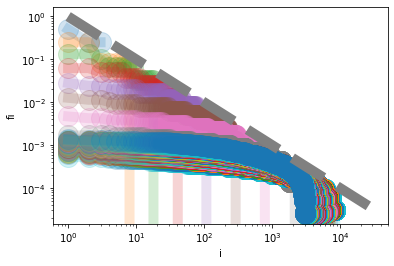

In [71]:
fig = plt.figure()

for l in range(L+1):
    freqs = layers[l].sorted_nodes
    x = np.linspace(1, len(freqs), len(freqs))
    plt.plot(x, freqs/np.sum(freqs), marker="o", ms=20, lw=10, alpha=0.2)

plt.plot(x, 1/x, color="gray", lw=10, ls="--")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("i")
plt.ylabel("fi")
fig.show()

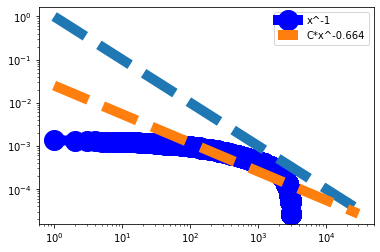

In [72]:
#freqs = np.sort(np.concatenate([l.sorted_nodes for l in layers]).ravel())[::-1]
#
#plt.plot(x, freqs/np.sum(freqs), marker="o", ms=20, c="gray", lw=10, label="x^-1")

layer_of_interest = layers[-1]
cnts = layer_of_interest.sorted_nodes/np.sum(layer_of_interest.sorted_nodes)
plt.plot(np.linspace(1, len(layer_of_interest), len(layer_of_interest)), cnts, marker="o", ms=20, c="blue", lw=10, label="x^-1")

x = np.linspace(1, len(layer_of_interest), len(layer_of_interest))
plt.plot(x, 1/x, lw=10, ls="--")

popt, pcov = curve_fit(lambda x, C, gamma: C * np.power(x, - gamma), x[50:10000], cnts[50:10000])
plt.plot(x, popt[0]*np.power(x,-popt[1]), lw=10, ls="--", label=f"C*x^-{round(popt[1],3)}")

plt.xscale("log")
plt.yscale("log")
#plt.ylim(1e-8,1)
plt.legend()

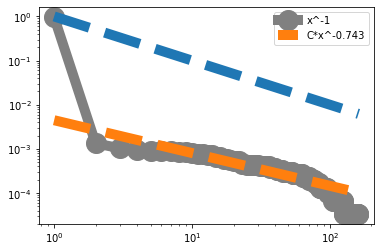

In [65]:
freqs = np.sort(np.unique(layers[-1].nodes,return_counts=True)[1])[::-1]
x = np.linspace(1, len(freqs), len(freqs))
plt.plot(x, freqs/np.sum(freqs), marker="o", ms=20, c="gray", lw=10, label="x^-1")

plt.plot(x, 1/x, lw=10, ls="--")

popt, pcov = curve_fit(lambda x, C, gamma: C * np.power(x, - gamma), x[5:], (freqs/np.sum(freqs))[5:])
plt.plot(x, popt[0]*np.power(x,-popt[1]), lw=10, ls="--", label=f"C*x^-{round(popt[1],3)}")


plt.xscale("log")
plt.yscale("log")
#plt.ylim(1e-5,5e-1)
plt.legend()

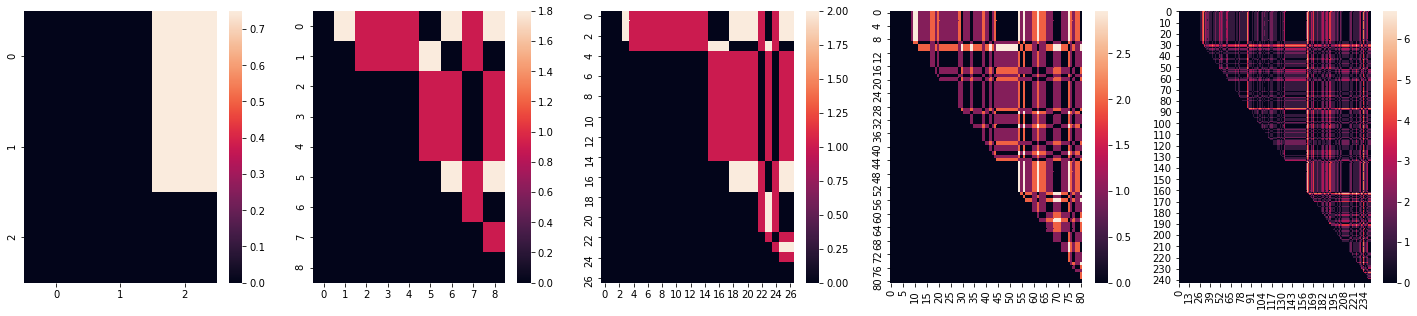

In [14]:
fig, axs = plt.subplots(1,5, figsize=(25,5))
for i,ax in enumerate(axs):
    loi = layers[i]
    leaves = loi.nodes[:1000]
    avg_leaves = loi.average
    sns.heatmap(list(map(lambda leaf_A: list(map(lambda leaf_B: np.abs(leaf_A[1]-leaf_B[1])/avg_leaves if leaf_A[0] < leaf_B[0] else 0,enumerate(leaves))),enumerate(leaves))), ax=ax)

## Histogram of distances

In [73]:
loi = layers[-1]
if len(loi)>5000:
    leaves = np.random.choice(loi.nodes,size=5000,replace=False)
else:
    leaves = loi.nodes
avg_leaves = loi.median
#distances = np.ravel(list(map(lambda leaf_A: list(map(lambda leaf_B: abs(leaf_A[1]-leaf_B[1])/avg_leaves if leaf_A[0] < leaf_B[0] else np.nan,enumerate(leaves))),enumerate(leaves))))
distances = np.ravel(list(map(lambda leaf: abs(leaf-avg_leaves),enumerate(leaves))))
distances = distances[~np.isnan(distances)]
distances = distances[distances>0]

data = dict()
data["1"]=distances

In [74]:
#import pickle
#with open("data_distances.pkl","wb") as file:
#    pickle.dump(data, file)
#with open("data_distances.pkl","rb") as file:
#    data = pickle.load(file)

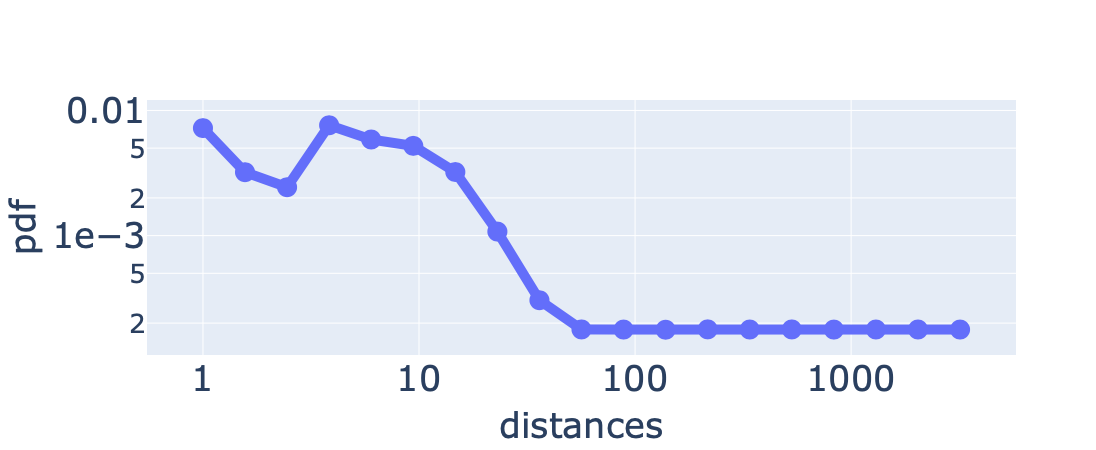

In [75]:
fig = go.Figure()

n_leaves = len(leaves)
for var,distances in data.items():
    bins=np.logspace(np.log10(distances.min()),np.log10(distances.max()), 20)
    #bins=np.linspace(distances.min(),distances.max(),20)
    bins, edges = np.histogram(distances, bins=bins, density=True)
    esges = (edges[1:]+edges[:1])/2
    fig.add_trace(go.Scatter(x=edges,y=bins,  marker=dict(size=20), line=dict(width=10), name=var))

fig.update_layout(xaxis=dict(title="distances", titlefont_size=35, tickfont_size=35, type="log", nticks= 5),
                 yaxis=dict(title="pdf", titlefont_size=35,tickfont_size=35, type="log", exponentformat="e", showexponent='all', nticks=5),
                 legend=dict(x=1.01,y=1,borderwidth=0.5,font_size=15,orientation="v"))

fig.show()
#fig.write_image("images/pdf_distances.pdf")
#fig.write_html("images/pdf_distances.html")

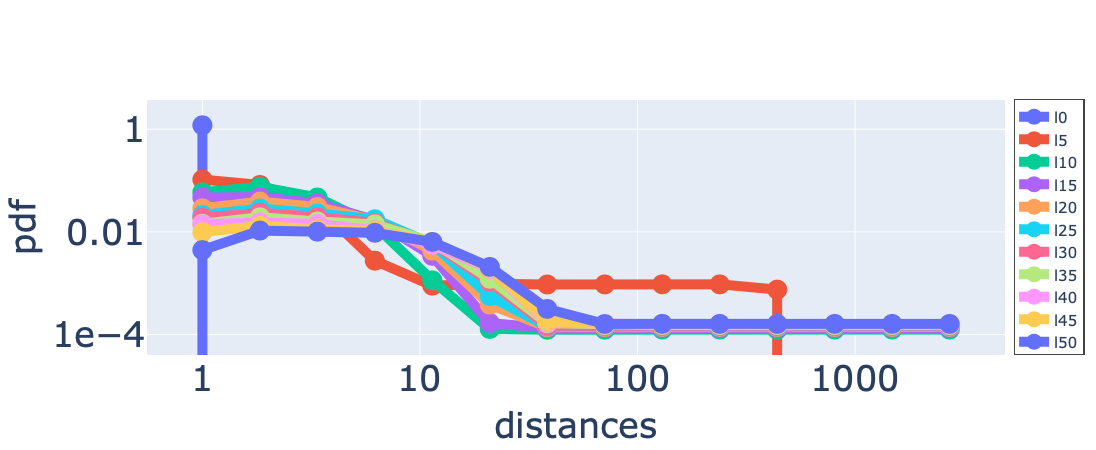

In [76]:
fig = go.Figure()

for loi in layers[::5]:
    if len(loi)>10000:
        leaves = np.random.choice(loi.nodes,size=10000,replace=False)
    else:
        leaves = loi.nodes
    avg_leaves = loi.median
    #distances = np.ravel(list(map(lambda leaf_A: list(map(lambda leaf_B: abs(leaf_A[1]-leaf_B[1])/avg_leaves if leaf_A[0] < leaf_B[0] else np.nan,enumerate(leaves))),enumerate(leaves))))
    distances = np.ravel(list(map(lambda leaf: abs(leaf-avg_leaves),enumerate(leaves))))
    distances = distances[~np.isnan(distances)]
    distances = distances[distances>0]
    
    n_leaves = len(leaves)

    bins=np.logspace(np.log10(distances.min()),np.log10(5e3), 15)
    #bins=np.linspace(distances.min(),distances.max(),20)
    bins, edges = np.histogram(distances, bins=bins, density=True)
    esges = (edges[1:]+edges[:1])/2
    fig.add_trace(go.Scatter(x=edges,y=bins,  marker=dict(size=20), line=dict(width=10), name=loi.__repr__().split(",")[0]))

fig.update_layout(xaxis=dict(title="distances", titlefont_size=35, tickfont_size=35, type="log", nticks= 4),
                 yaxis=dict(title="pdf", titlefont_size=35,tickfont_size=35, type="log", exponentformat="e", showexponent='all', nticks=4),
                 legend=dict(x=1.01,y=1,borderwidth=0.5,font_size=15,orientation="v"))

fig.show()
fig.write_image("images/distance_pdf_layers.pdf")
fig.write_html("images/distance_pdf_layers.html")

In [ ]:
np.average(np.abs(np.array(layers[-1].nodes)[1:]-layers[-1].nodes[:-1]))/layers[-1].average

In [ ]:
L = 10
nl = 3
previous_layer = None
M = []
h = []
nz = []
for istat in range(1000):
    if istat % (1000/10) == 0:
            print(istat)
    previous_layer = first_layer("l0", nl)
    previous_layer.sample()
    for il,l in enumerate(range(L)):
        new_layer = layer(f"l{il+1}", nl)
        new_layer.sample(previous_layer)
        previous_layer = new_layer
    previous_layer = None
    M.append(np.sum(new_layer.nodes))
    h.append(len(np.unique(new_layer.nodes)))
    nz.append((np.array(new_layer.nodes) > 0).sum())

In [ ]:
x = np.linspace(min(M), max(M), 10)

fig,ax = plt.subplots(1,2, figsize=(15,9))

popt,pcov = curve_fit(lambda x, C, gamma: C*np.power(x,gamma), M, h)
#ax[0].plot(x,popt[0]*np.power(x,popt[1]))
print(popt)
#ax[0].scatter(M,h)
ax[0].scatter(M,nz)


ax[0].set_xscale("log")
ax[0].set_yscale("log")

means, edges, _ = binned_statistic(M,h, statistic="mean")
var, edges, _ = binned_statistic(M,h, statistic="std")
var = var*var
cnt, edges, _ = binned_statistic(M,h, statistic="count")


x = np.linspace(min(means), max(means), 10)
ax[1].scatter(means,var)
ax[1].plot(x,x)
ax[1].plot(x,1e-2*x**2)

ax[1].set_xscale("log")
ax[1].set_yscale("log")

In [ ]:
len(new_layer)

In [ ]:
counts, _, _ = plt.hist(layers[-1].nodes, color="gray")

plt.yscale("log")
#plt.xscale("log")
plt.show()

In [ ]:
m = 60
n = m/(m-1)
p = 1/m
N = 1000
counts, _, _ = plt.hist([rng.negative_binomial(n,p) for _ in range(N)], color="gray")
plt.vlines([n*(1-p)/p],1,1e4)
plt.vlines([m],1,1e4, lw=5, color="red", ls="--")


plt.yscale("log")
#plt.xscale("log")
plt.show()

# Hyperparameters

Gaussian scaling vs exponent L=50

In [ ]:
fig = go.Figure()

fig.add_scatter(x=scaling, y=scaling_exp)
fig.add_trace(go.Scatter(x=[0,1],y=[1,1],mode="lines",line = dict(width=5, dash="dash")))

fig.update_traces(marker_size=25, line_width=10)
fig.update_layout(xaxis=dict(title="Scaling", exponentformat = 'e', tickfont=dict(size=20), title_font_size=35),
                  yaxis_title="Exponent",
                  yaxis=dict(tickfont=dict(size=20), title_font=dict(size=35)))
fig.update_layout(showlegend=False)
fig.show()
fig.write_image("exp_scaling.png")

In [ ]:
fig = go.Figure()

fig.add_scatter(x=variance, y=mean_distance, name="average distance")
#fig.add_scatter(x=variance, y=exponent, name="exponent")

fig.update_traces(marker_size=20)
fig.update_layout(xaxis=dict(title="Variance", exponentformat = 'e', tickfont=dict(size=20), title_font_size=35),
                  yaxis_title="Average distance",
                  yaxis=dict(tickfont=dict(size=20), title_font=dict(size=35)),
                 xaxis_type="log")
fig.show()
fig.write_image("exp_scaling.pdf")

In [ ]:
avg = [np.average(np.abs(np.array(l.nodes)[1:]-l.nodes[:-1]))/l.average for l in layers]
#maxs = [np.max(np.abs(np.array(l.nodes)[1:]-l.nodes[:-1]))/l.average for l in layers]

fig = go.Figure()

fig.add_scatter(y=avg, x=list(range(len(avg))), name="average distance", line=dict(width=10, color="gray"))
#fig.add_scatter(y=maxs, x=list(range(len(avg))), name="maximum distance", line=dict(width=10, color="gray"))


fig.update_traces(marker_size=20)
fig.update_layout(xaxis=dict(title="Layer", exponentformat = 'e', tickfont=dict(size=20), title_font_size=35),
                  yaxis_title="Distance*",
                  yaxis=dict(tickfont=dict(size=20), title_font=dict(size=35)))
fig.show()
fig.write_image("distance_layer_negativem2.png")

## gamma

In [ ]:
def get_exp(layer)->float:
    try:
        layer_of_interest = layer
        cnts = layer_of_interest.sorted_nodes/np.sum(layer_of_interest.sorted_nodes)
        x = np.linspace(1, len(layer_of_interest), len(layer_of_interest))

        popt, pcov = curve_fit(lambda x, C, gamma: C * np.power(x, - gamma), x[5:10000], cnts[5:10000])
        return popt[1]
    except:
        return None
    
exps = list(map(get_exp, layers))

In [ ]:
x = np.linspace(1,len(layers),len(layers))

fig = go.Figure()

fig.add_scatter(x = x, y=exps, name="exponents", line=dict(width=10, color="gray"))
fig.add_trace(go.Scatter(y=[1,1], x=[0,len(layers)], name="1", mode="lines", line=dict(width=10, color="blue", dash="dash")))


fig.update_traces(marker_size=20)
fig.update_layout(xaxis=dict(title="Layer", exponentformat = 'e', tickfont=dict(size=20), title_font_size=35),
                  yaxis_title="gamma",
                  yaxis=dict(range=(0,2.5),tickfont=dict(size=20), title_font=dict(size=35)))
fig.show()

In [ ]:
import gc
gc.collect()